Part 2 which will train Faster R-CNN with the previously trained Resnet18 car classifier as backbone model.

In [41]:
# !pip install --upgrade albumentations

In [1]:
import os, random, cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch, torchvision
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

seed = 42
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [2]:
A.__version__

'0.5.2'

In [2]:
print(torch.cuda.get_device_name(0)) 

Tesla T4


## Download data

In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# !wget http://images.cocodataset.org/zips/val2017.zip

# # copy to drive to save time 

# !cp /content/cars_train.tgz /content/drive/MyDrive/Datasets
# !cp /content/val2017.zip /content/drive/MyDrive/Datasets

In [ ]:
# copy dataset from drive

a = '/content/cars_train.tgz'
b = '/content/drive/MyDrive/Datasets/cars_train.tgz'

import shutil

shutil.copyfile(b,a)

In [7]:
# extract data
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!tar -xzf /content/car_devkit.tgz
!tar -xzf /content/cars_train.tgz

--2021-02-21 09:20:14--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.43MB/s    in 0.2s    

2021-02-21 09:20:14 (1.43 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [3]:
ROOT_DIR = '/content/cars_train/'
cars_image_ids = os.listdir(ROOT_DIR)
print('Total images',len(cars_image_ids))

Total images 8144


## Prepare Annotations

In [4]:
# make dataframe of annotation values

import scipy.io

mat = scipy.io.loadmat('/content/devkit/cars_train_annos.mat')
annotations = mat['annotations'][0]
annotations_array = []

for i in annotations:
  x1= i[0].item()
  y1= i[1].item()
  x2= i[2].item()
  y2= i[3].item()
  image_id= i[5].item()
  a = np.array([image_id, x1,x2,y1,y2]).reshape(1,-1)
  annotations_array.append(a)

cols = ['image_id', 'x1','x2','y1','y2']
a = np.array(annotations_array).reshape(-1,5)

df = pd.DataFrame(a,columns=cols)

df.head()

,image_id,x1,x2,y1,y2
0,00001.jpg,39,569,116,375
1,00002.jpg,36,868,116,587
2,00003.jpg,85,601,109,381
3,00004.jpg,621,1484,393,1096
4,00005.jpg,14,133,36,99


In [5]:
# turn them to int
df = df.astype({'x1': 'int32', 'x2': 'int32', 
                'y1': 'int32', 'y2': 'int32'})

df.dtypes

image_id    object
x1           int32
x2           int32
y1           int32
y2           int32
dtype: object

## Show some Images

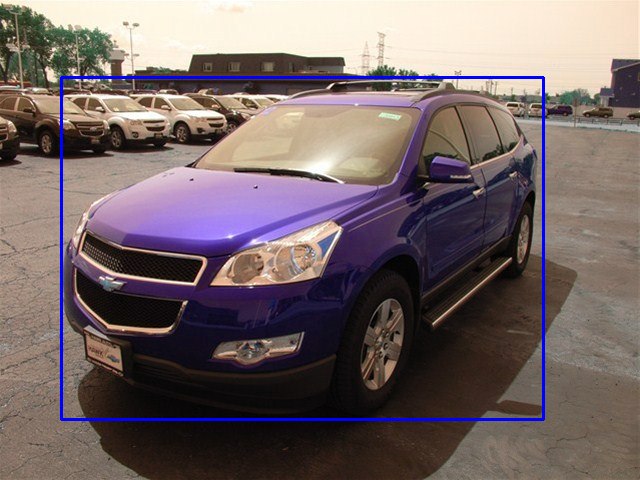

In [40]:
# sample dataset

img = cars_image_ids[26]
a = df[df['image_id'] == img]
x1 = a['x1'].values
y1 = a['y1'].values
x2 = a['x2'].values
y2 = a['y2'].values
img = cv2.imread(ROOT_DIR + img)
cv2.rectangle(img, (x1,y1), (x2, y2), (0,0,255), 2)
im = img
Image.fromarray(im)

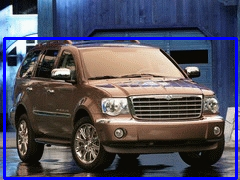

In [41]:
# sample dataset

img = cars_image_ids[7]
a = df[df['image_id'] == img]
x1 = a['x1'].values
y1 = a['y1'].values
x2 = a['x2'].values
y2 = a['y2'].values
img = cv2.imread(ROOT_DIR + img)
cv2.rectangle(img, (x1,y1), (x2, y2), (0,0,255), 2)
im = img
Image.fromarray(im)

## Prepare Dataset

In [6]:
# create dataset

class CarsDataset(Dataset):

  def __init__(self, root_dir, image_ids, annotations_df, transform=None):
    self.images_dir = root_dir
    self.image_ids = image_ids
    self.annotations = annotations_df
    self.transform = transform

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, index):

    image_id = self.image_ids[index]
    image = cv2.imread(self.images_dir + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    anno = self.annotations[self.annotations['image_id'] == image_id] # contains boxes,labels,image_id
    # take boxes
    x1 = anno['x1'].values
    y1 = anno['y1'].values
    x2 = anno['x2'].values
    y2 = anno['y2'].values

    boxes = torch.as_tensor([[x1[0], y1[0], x2[0], y2[0]]], 
                            dtype=torch.float32)
    # only cars so 1 label
    labels = torch.ones((1,), dtype=torch.int64)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((1,), dtype=torch.int64)

    target = {}
    target['area'] = area
    target['labels'] = labels
    target['iscrowd'] = iscrowd

    if self.transform:
      image_transforms = {
                          'image': image,
                          'bboxes': boxes,
                          'labels': labels
                         }
            
      image_transforms = self.transform(**image_transforms)
      image = image_transforms['image']
      image = image.type(torch.float32) # freeze for imshow
      image/=255.0 # freeze for imshow
      
      target['boxes'] = torch.as_tensor(image_transforms['bboxes'], dtype=torch.float32)
      target['boxes'] = target['boxes'].reshape(-1, 4) # recheck boxes dimension due to error
      
      return image, target

## Fix bbox boundaries bug

Bug: Expected x_max for bbox (tensor(0.0972), tensor(0.1159), tensor(1.2448), tensor(0.6758), tensor(1)) to be in the range [0.0, 1.0], got 1.2447916269302368.

The bug is due to boxes locations are more than 512(the image size for training) when we resize image in transforms, by excluding samples with image size above 512 the bug can be fixed.

In [7]:
# exclude images below some image size

def excluding_below_size(image_ids, maximum_size=[512, 512]):

  new_image_ids = []
  for id in image_ids:
    im = cv2.imread(ROOT_DIR + id)
    if im.shape[0] >= maximum_size[0] and im.shape[1] >= maximum_size[1]:
      continue
    new_image_ids.append(id)  
  print("Number of excluded", len(new_image_ids))  
  return new_image_ids

# solve the bbox boundaries error

def check_bbox_error(bbox, status=False):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums
    ['x_min', 'y_min', 'x_max', 'y_max']"""
    for i in range(4):
        if not 0 <= bbox[i]:
          status = True
        if not bbox[i] <= 1:
          status = True
    return bbox, status    
            
def normalize_bbox(bbox, image_size=[512,512]):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    """
    x_min, y_min, x_max, y_max = bbox[:4]
    normalized_bbox = [x_min / image_size[0], y_min / image_size[1], x_max / image_size[0], y_max / image_size[1]]
    return normalized_bbox

# exclude images with bbox error
def exclude_with_bbox_error(images_ids):

  number_excluded= 0
  new_samples = []
  for a in images_ids:
      anno = df[df.image_id == a]
      x1 = anno['x1'].values
      y1 = anno['y1'].values
      x2 = anno['x2'].values
      y2 = anno['y2'].values
      box = [x1,y1,x2,y2]
      box = normalize_bbox(box)
      box, status = check_bbox_error(box)
      if status: 
        new_samples.append(a)
        number_excluded+=1
  print("Number of excluded",number_excluded)
  return new_samples

In [8]:
new_cars_images_ids = excluding_below_size(cars_image_ids)
fixed_cars_images_ids = exclude_with_bbox_error(new_cars_images_ids)
print("Total image ids", len(fixed_cars_images_ids))

Number of excluded 5955
Number of excluded 2557
Total image ids 2557


Note: with 1024 size i got almost 5000~ images, but for training with that size it'll consume more time/computation so took 512 .

In [9]:
# prepare dataset, dataloader

def collate_fn(batch):
    return tuple(zip(*batch))

x_train, x_test = train_test_split(fixed_cars_images_ids, test_size=0.2, random_state=seed)

BATCH_SIZE = 64
IMAGE_SIZE = [512, 512]

def get_train_transforms():
    return A.Compose([ 
                      A.HorizontalFlip(p=0.5),
                      A.RandomBrightnessContrast(p=0.2),
                      A.ToGray(p=0.1),
                      A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=1),
                      ToTensorV2()
                      ],
            bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        ))
    
def get_val_transforms():
    return A.Compose([ 
                      A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=1),
                      ToTensorV2()
                      ])
    
train_dataset = CarsDataset(ROOT_DIR, x_train, df, transform=get_train_transforms())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = CarsDataset(ROOT_DIR, x_test, df, transform=get_val_transforms())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 2045 and Test Dataset 512


In [10]:
train_dataset[10] # check output of dataset

(tensor([[[0.6588, 0.6588, 0.6588,  ..., 0.9098, 0.9098, 0.9059],
          [0.6588, 0.6588, 0.6588,  ..., 0.9098, 0.9059, 0.9059],
          [0.6627, 0.6627, 0.6627,  ..., 0.9098, 0.9059, 0.9059],
          ...,
          [0.6314, 0.6118, 0.6157,  ..., 0.4510, 0.4824, 0.5059],
          [0.6118, 0.5961, 0.5961,  ..., 0.5098, 0.5725, 0.6039],
          [0.6000, 0.5961, 0.6118,  ..., 0.5490, 0.5569, 0.5882]],
 
         [[0.7255, 0.7255, 0.7255,  ..., 0.9294, 0.9294, 0.9255],
          [0.7255, 0.7255, 0.7255,  ..., 0.9294, 0.9255, 0.9255],
          [0.7176, 0.7176, 0.7176,  ..., 0.9294, 0.9255, 0.9255],
          ...,
          [0.5686, 0.5451, 0.5490,  ..., 0.4196, 0.4431, 0.4588],
          [0.5451, 0.5294, 0.5333,  ..., 0.4784, 0.5294, 0.5529],
          [0.5333, 0.5294, 0.5451,  ..., 0.5137, 0.5137, 0.5373]],
 
         [[0.7647, 0.7647, 0.7647,  ..., 0.9529, 0.9529, 0.9490],
          [0.7647, 0.7647, 0.7647,  ..., 0.9529, 0.9490, 0.9490],
          [0.7608, 0.7608, 0.7608,  ...,

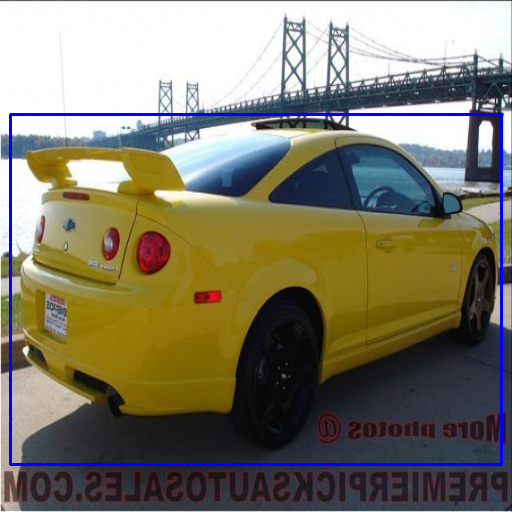

In [42]:
# show sample from dataset

# sample dataset
id = 30

img = train_dataset[id][0]
x1 = train_dataset[id][1]['boxes'].numpy()[0][0]
y1 = train_dataset[id][1]['boxes'].numpy()[0][1]
x2 = train_dataset[id][1]['boxes'].numpy()[0][2]
y2 = train_dataset[id][1]['boxes'].numpy()[0][3]

img = img.mul(255).permute(1, 2, 0).byte().numpy()
cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
Image.fromarray(img)

## Prepare Model

In [10]:
# re-create previous model
class ResnetCarClassifier(torch.nn.Module):
    
    def __init__(self):
        super(ResnetCarClassifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        y = self.sigmoid(x)
        return y

model_path = '/content/drive/MyDrive/train/resnet_carclassifer.bin'
backbone = ResnetCarClassifier()
saved_model = torch.load(model_path)
backbone.load_state_dict(saved_model)

# to exclude sigmoid, linear, avg_norm layer
class NewResnetCarClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NewResnetCarClassifier, self).__init__()
        self.model = torch.nn.Sequential(*(list(backbone.model.children())[:-2]))
        self.out_channels = 512 # resnets output number of features

    def forward(self, x):
        y = self.model(x)
        return y

new_backbone = NewResnetCarClassifier()
new_backbone = new_backbone.requires_grad_(False) # freeze backbone

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(new_backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)  

print("Total trainble parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))

Total trainble parameters 29149269


In [10]:
# find backbone output features size

new_backbone.cuda(0)

for i in train_dataset:
  im = train_dataset[0][0].reshape(1, 3,512, 512).cuda(0)
  op = new_backbone(im)
  print(op.shape)
  break

torch.Size([1, 512, 16, 16])


In [ ]:
# find model output

images,targets = next(iter(train_loader))
model.cuda(0)
model.train()
images = list(image.cuda(0) for image in images)
targets = [{k: v.cuda(0) for k, v in t.items()} for t in targets]
# model.eval()
# with torch.no_grad():
loss_dict = model(images, targets)
sum(loss for loss in loss_dict.values())

## Training

In [11]:
# metric

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [12]:
# training

def train_model(model, EPOCHS, optimizer, scheduler, BATCH_SIZE, train_loader, val_loader):

  TRAIN_LOSS = []
  VAL_LOSS = []
  MIN_LOSS = 20.0
  model_save_path = '/content/car_detector.bin'

  loss_hist = Averager()

  TRAIN_STEP = len(train_loader)/BATCH_SIZE # to calculate loss
  VALID_STEP = len(val_loader)/BATCH_SIZE

  for epoch in range(1, EPOCHS+1):
    print("Epoch", epoch)
    model.train()
    for (images, targets) in train_loader:
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_hist.send(losses.item())
      losses.backward()
      optimizer.step()

    train_l = loss_hist.value
    TRAIN_LOSS.append(train_l)
    total = 0
    correct = 0 
    print("Training Loss:", train_l)
    loss_hist.reset()
    # model.eval()

    for (images, targets) in val_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      with torch.no_grad():
        loss_dict = model(images, targets)
      val_loss = sum(loss for loss in loss_dict.values())
      loss_hist.send(val_loss.item())

    valid_l = loss_hist.value
    print("Val Loss:", valid_l)
    VAL_LOSS.append(valid_l)

    if scheduler is not None:
      scheduler.step()

    if MIN_LOSS > min(VAL_LOSS):
      MIN_LOSS = min(VAL_LOSS)
      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, model_save_path)
      print('Model Saved...')
  return VAL_LOSS, TRAIN_LOSS  

In [13]:
# train model

LR = 0.0001
EPOCHS = 10
device = 'cuda'
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)

val_loss, train_loss = train_model(model, EPOCHS, optimizer, lr_scheduler, 
                                            BATCH_SIZE, train_loader, val_loader)

Epoch 1
Training Loss: 0.4927969556301832
Val Loss: 0.270554356276989
Model Saved...
Epoch 2
Training Loss: 0.22957567870616913
Val Loss: 0.22585890628397465
Model Saved...
Epoch 3
Training Loss: 0.1892172135412693
Val Loss: 0.23039760068058968
Epoch 4
Training Loss: 0.17347602657973765
Val Loss: 0.22868617810308933
Epoch 5
Training Loss: 0.16499451287090777
Val Loss: 0.21996073238551617
Model Saved...
Epoch 6
Training Loss: 0.16005509421229364
Val Loss: 0.2368883267045021
Epoch 7
Training Loss: 0.15843586660921574
Val Loss: 0.21684627048671246
Model Saved...
Epoch 8
Training Loss: 0.14393735099583865
Val Loss: 0.2409229427576065
Epoch 9
Training Loss: 0.14183459039777518
Val Loss: 0.22762746922671795
Epoch 10
Training Loss: 0.1389789417386055
Val Loss: 0.2287617288529873


## Training curves

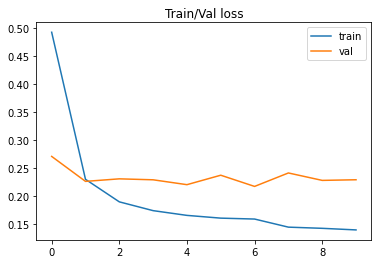

In [14]:
# training curves

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Train/Val loss')
plt.show()

## Results

In [18]:
imgs = []
preds = []
for s in range(2):
  img, _ = val_dataset[s]
  imgs.append(img)
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  preds.append(prediction)

In [49]:
prediction

[{'boxes': tensor([[200.9661,  95.1190, 361.4349, 260.0029],
          [264.8347,  14.0086, 396.0485, 228.6946],
          [338.6738,  37.8197, 411.1425, 233.6310],
          [198.1596,   8.1178, 345.3275, 216.4239],
          [368.2318,  93.1210, 433.8549, 256.4920],
          [160.0497,  42.8055, 292.7790, 226.3639],
          [155.7417, 119.0044, 303.7915, 251.2793],
          [434.5750,  88.8298, 471.5120, 243.7386],
          [398.3728,   3.7417, 461.9946, 206.1307],
          [412.6461,  95.8265, 458.2773, 254.6826],
          [128.7456,  21.9983, 247.5990, 204.3155],
          [442.9313,  51.0095, 482.7574, 246.4075],
          [509.1452, 122.1797, 512.0000, 433.9211],
          [ 98.3162,  85.5353, 202.0875, 223.8037],
          [250.0147,  48.9123, 377.7704, 181.5391],
          [ 88.5443,   0.0000, 163.1804, 177.5751],
          [173.8454, 198.0847, 284.1384, 328.3621],
          [160.5895, 123.5196, 372.1132, 315.5416],
          [507.0964,  92.5390, 512.0000, 403.1493],
   

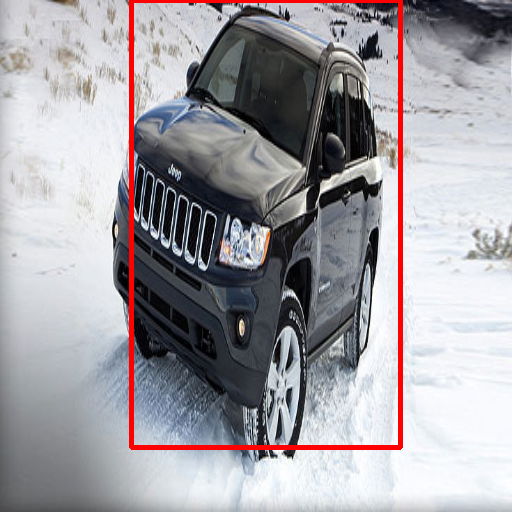

In [19]:
img1 = imgs[0].mul(255).permute(1, 2, 0).byte().numpy()
b = preds[0][0]['boxes'][0].cpu().numpy()
cv2.rectangle(img1, (b[0], b[1]), (b[2], b[3]), (255,0,0), 3)
Image.fromarray(img1)

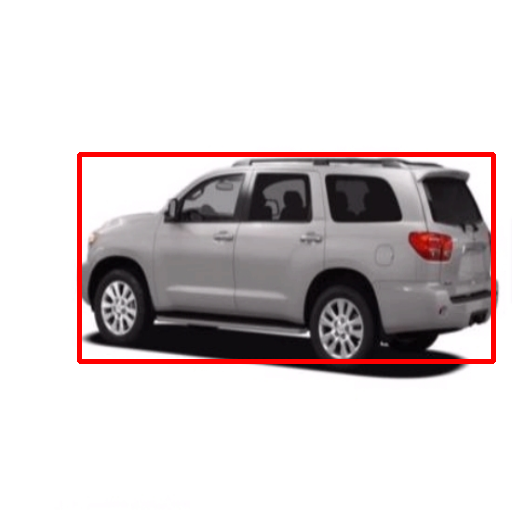

In [20]:
img1 = imgs[1].mul(255).permute(1, 2, 0).byte().numpy()
b = preds[1][0]['boxes'][0].cpu().numpy()
cv2.rectangle(img1, (b[0], b[1]), (b[2], b[3]), (255,0,0), 3)
Image.fromarray(img1)

Summary: Here we finish training our car detector, First we trained a resnet18 model, freezed its parameters and use it as backbone in a faster-rcnn model. Trained it further for some epochs. This is not SOTA training, there are improvements to be made. And most of the time a imagenet pre-trained model in faster rcnn works better. But this method saves training parameters for object detector.